In [20]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [21]:
import torch
import scanpy as sc

In [22]:
DATASET_NAME = "LUNG-CITE"
BASE_DATA_DIR = os.path.join("..", "datasets", "data", "processed")  
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
from utils.data_utils import dataset_config, load_dataset

hetero_data, data_dict = load_dataset(DATASET_NAME, BASE_DATA_DIR, DEVICE)

c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [24]:
from utils.graph_utils import (
    calculate_modality_jaccard,
    plot_degree_distributions,
    plot_modality_umaps
)
import matplotlib.pyplot as plt

def visualize_individual_metrics(hetero_data, data_dict, config):
    """Visualize per-modality graph metrics using utils"""
    modalities = config["modalities"]
    
    # Calculate and print Jaccard scores
    jaccard_results = {
        m: calculate_modality_jaccard(hetero_data['cell', m, 'cell'].edge_index)
        for m in modalities
    }
    print("Neighborhood Consistency Scores:")
    for mod, score in jaccard_results.items():
        print(f"- {mod}: {score:.3f}")
    
    # Plot distributions
    plot_degree_distributions(hetero_data, modalities)
    plot_modality_umaps(data_dict, modalities)
    
    plt.show()

# visualize_individual_metrics(hetero_data, data_dict, dataset_config[DATASET_NAME]) - run if you want to see metrics for individual modalities

In [25]:
import torch
print(torch.__version__)          # e.g., 2.0.1
print(torch.version.cuda)         # e.g., 11.7 (or "None" for CPU-only)

2.5.1
12.4


In [26]:
import torch
print(torch.__version__)          # PyTorch version
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)         # CUDA version (e.g., 11.7)

2.5.1
True
12.4


In [27]:
import scanpy as sc

modalities = dataset_config[DATASET_NAME]["modalities"]
print(modalities)

data = {}

for modality in modalities:
    data[modality] = sc.read_h5ad(f"./../datasets/data/processed/{DATASET_NAME}_{modality}.h5ad")

cell_metadata = data[modalities[0]].obs.copy()

data

['ADT', 'RNA']


{'ADT': AnnData object with n_obs × n_vars = 10470 × 52
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'count', 'percentile', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_apca'
     varm: 'APCA',
 'RNA': AnnData object with n_obs × n_vars = 10470 × 3000
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_pca'
     varm: 'PCs'}

In [28]:
import torch

processed = {m: {'x': torch.tensor(data[m].X, dtype=torch.float)} for m in modalities}
processed

# processed = {m: {'x': torch.tensor(data[m].obsm['X_glue'], dtype=torch.float)} for m in modalities}
# processed - for the match data with precomputed latent representations

{'ADT': {'x': tensor([[-0.1067,  0.2336, -0.3761,  ...,  0.0417,  0.7129,  1.7810],
          [-0.0816,  0.6819,  0.1002,  ...,  2.8420,  0.1367, -0.2340],
          [ 0.1335, -0.1355, -0.0772,  ..., -0.8012, -0.0301, -0.7497],
          ...,
          [-0.2312,  0.4648,  0.3953,  ...,  0.1589, -0.9881,  0.5103],
          [-0.3114, -1.4292, -0.3896,  ...,  0.0273,  0.2220,  1.4590],
          [-0.4793,  0.5241, -1.0956,  ...,  0.8601, -0.9881,  0.5941]])},
 'RNA': {'x': tensor([[-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          ...,
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625,  6.1826, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567]])}}

In [29]:
from torch_geometric.data import HeteroData

# (1) Assign attributes after initialization,
hetero_data = HeteroData(processed)
hetero_data['cell'].x = torch.cat([hetero_data[m].x for m in modalities], dim=1)
hetero_data['cell'].metadata = cell_metadata 
hetero_data

HeteroData(
  ADT={ x=[10470, 52] },
  RNA={ x=[10470, 3000] },
  cell={
    x=[10470, 3052],
    metadata=                  orig.ident  nCount_RNA  nFeature_RNA  tissue  group  volume  \
GACGTGCTCAGAGACG           0       753.0           430       0      2       1   
GATTCAGTCACTGGGC           0      4848.0          1570       1      4       0   
CTCGAGGGTATTACCG           0       769.0           488       0      3       1   
TAGACCACATGGGAAC           0      1190.0           577       1      5       0   
TGTGGTAGTCACAAGG           0      1786.0           826       0      0       0   
...                      ...         ...           ...     ...    ...     ...   
AACTGGTCAATAGCGG           0      3010.0          1276       1      4       0   
TGTCCCAGTTGAGTTC           0      1791.0          1033       1      4       0   
CTCCTAGTCACCTCGT           0      1814.0           792       0      2       1   
CACCAGGGTACGCTGC           0       105.0            89       0      0       0   
GT

In [30]:
from torch_geometric.nn import knn_graph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hetero_data = hetero_data.to(device)

for m in modalities:
    hetero_data['cell', m, 'cell'].edge_index = knn_graph(
        hetero_data[m].x,
        k=10,
        cosine=True,
        num_workers=16
    )

In [31]:
hetero_data = hetero_data.cpu() 
output_path = os.path.join(os.path.join(BASE_DATA_DIR, DATASET_NAME), f"{DATASET_NAME}_processed.pt")
torch.save(hetero_data, output_path)
print(f"Saved processed data to {output_path}")

Saved processed data to ..\datasets\data\processed\LUNG-CITE\LUNG-CITE_processed.pt


In [32]:
output_path = os.path.join(os.path.join(BASE_DATA_DIR, DATASET_NAME), f"{DATASET_NAME}_processed.pt")
loaded_data = torch.load(output_path)
hetero_data = loaded_data.to(DEVICE)  # Move back to GPU if needed

C:\Users\sonia\AppData\Local\Temp\ipykernel_30228\2055880503.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(output_path)


In [33]:
import torch
from torch_geometric.loader import NeighborLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hetero_data = hetero_data.to(device)

num_cells = hetero_data['cell'].x.size(0)
cell_idx = torch.arange(num_cells, device=device)

neighbor_loader = NeighborLoader(
    hetero_data,
    num_neighbors={
        ('cell', m, 'cell'): [5, 5] for m in modalities
    },
    input_nodes=('cell', cell_idx),
    batch_size=64  # choose an appropriate batch size for your memory constraints
)

for batch in neighbor_loader:
    print(batch)

HeteroData(
  ADT={
    x=[0, 52],
    n_id=[0],
  },
  RNA={
    x=[0, 3000],
    n_id=[0],
  },
  cell={
    x=[4096, 3052],
    metadata=                  orig.ident  nCount_RNA  nFeature_RNA  tissue  group  volume  \
GACGTGCTCAGAGACG           0       753.0           430       0      2       1   
GATTCAGTCACTGGGC           0      4848.0          1570       1      4       0   
CTCGAGGGTATTACCG           0       769.0           488       0      3       1   
TAGACCACATGGGAAC           0      1190.0           577       1      5       0   
TGTGGTAGTCACAAGG           0      1786.0           826       0      0       0   
...                      ...         ...           ...     ...    ...     ...   
AACTGGTCAATAGCGG           0      3010.0          1276       1      4       0   
TGTCCCAGTTGAGTTC           0      1791.0          1033       1      4       0   
CTCCTAGTCACCTCGT           0      1814.0           792       0      2       1   
CACCAGGGTACGCTGC           0       105.0          

In [34]:
from model.model import HeteroGraphAE, GraphAELightningModule

In [35]:
# Hyperparameters.
in_channels = hetero_data['cell'].x.size(1)
hidden_channels = 512
latent_channels = 256   # Dimensionality of the latent space.
num_layers = 2
learning_rate = 1e-3
n_epochs = 1 # change to 500 for full training

# Instantiate the Lightning module.
model = GraphAELightningModule(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    latent_channels=latent_channels,
    modalities=modalities,
    num_layers=num_layers,
    learning_rate=learning_rate,
    total_epochs=n_epochs,
    warmup_epochs=10,
    num_clusters=20,
    clustering_weight=.1
)

In [36]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',         # monitor your training loss
    dirpath='checkpoints',        # directory to save checkpoints
    filename='graph_ae-{epoch:02d}-{train_loss:.2f}',
    save_top_k=1,                 # save the best model
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='train_loss',
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode='min'
)

trainer = Trainer(
    max_epochs=n_epochs,
    accelerator="gpu",
    devices=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)
trainer.fit(model, train_dataloaders=neighbor_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\sonia\Documents\University\Cambridge\L65\Multi Omics Integration Project\MultiOmicsIntegration\evaluation\checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | model        | HeteroGraphAE | 4.4 M  | train
  | other params | n/a           | 5.1 K  | n/a  
-------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M   

Epoch 0: 100%|██████████| 164/164 [00:47<00:00,  3.43it/s, v_num=1, train_loss=31.30, recon_loss=29.30, cluster_loss=21.00]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 31.349
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 164/164 [00:48<00:00,  3.39it/s, v_num=1, train_loss=31.30, recon_loss=29.30, cluster_loss=21.00]


In [37]:
# Inference on full data:
model.eval()
with torch.no_grad():
    # Move data to the same device as the model.
    hetero_data = hetero_data.to(model.device)
    z = model(hetero_data)
    # For example, reconstruct edge probabilities using one set of edges.
    pos_edge_index = list(hetero_data.edge_index_dict.values())[0]
    pred_edge_probs = model.model.decode(z, pos_edge_index)
    print(f"nde_embedding: {z}")
    print("Predicted edge probabilities:", pred_edge_probs)


nde_embedding: tensor([[ 0.0171, -0.4642,  0.1655,  ..., -0.1748,  0.3987, -0.1002],
        [ 0.0198, -0.0451,  0.8545,  ..., -0.9513,  0.1771, -2.3784],
        [ 0.2589, -0.3172,  0.1039,  ...,  0.0894,  0.6340, -0.1244],
        ...,
        [ 0.1844, -0.1422,  0.1364,  ...,  0.0259,  0.3690, -0.4981],
        [ 0.2749, -0.3917,  0.3465,  ..., -0.0400,  0.3313, -0.3279],
        [ 0.2675, -0.2623,  0.3795,  ..., -0.0782,  0.3255, -0.4772]])
Predicted edge probabilities: tensor([1., 1., 1.,  ..., 1., 1., 1.])


Evaluation metrics

In [58]:
latent_embedding = z
adata_eval = sc.AnnData(X=latent_embedding, obs=hetero_data['cell'].metadata.copy())
adata_eval.obsm["emb"] = latent_embedding


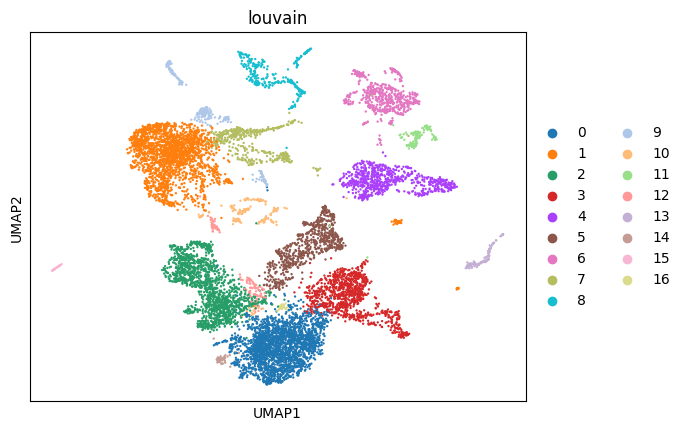

In [59]:
sc.pp.neighbors(adata_eval, use_rep='emb')         # Build neighbor graph using the latent embedding.
sc.tl.louvain(adata_eval, resolution=0.5)            # Run Louvain clustering.
sc.tl.umap(adata_eval)                               # Compute UMAP coordinates.
sc.pl.embedding(adata_eval, color='louvain', basis='umap')  # Visualize the UMAP colored by Louvain clusters.


In [61]:
gt = adata_eval.obs['celltype'].tolist()   # True labels.
pred = adata_eval.obs['louvain'].tolist()     # Louvain cluster labels.

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(gt, pred)
nmi = normalized_mutual_info_score(gt, pred)

print("Adjusted Rand Index:", ari)
print("Normalized Mutual Information:", nmi)


Adjusted Rand Index: 0.5339350989696677
Normalized Mutual Information: 0.671929416066796


In [62]:
results_dir = "results"
metrics_dir = os.path.join(results_dir, "metrics")
figures_dir = os.path.join(results_dir, "figures")

os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

In [63]:
metrics = {
    "dataset_name": DATASET_NAME,
    "in_channels": in_channels,
    "hidden_channels": hidden_channels,
    "latent_channels": latent_channels,
    "num_layers": num_layers,
    "learning_rate": learning_rate,
    "n_epochs": n_epochs,
    "ARI": ari,  
    "NMI": nmi   
}

In [64]:
import pandas as pd

# Convert the metrics dictionary into a DataFrame and save as CSV.
df_metrics = pd.DataFrame([metrics])
csv_file = os.path.join(metrics_dir, f"{DATASET_NAME}_results.csv")
df_metrics.to_csv(csv_file, index=False)
print(f"Metrics saved to {csv_file}")

# Save the UMAP plot with Louvain clusters as a PNG.
# Re-run the plotting command with show=False to capture the figure.
sc.pl.embedding(adata_eval, color='louvain', basis='umap', show=False)
# Save the current figure.
umap_fig_path = os.path.join(figures_dir, "umap_louvain.png")
plt.savefig(umap_fig_path)
plt.close()
print(f"UMAP figure saved to {umap_fig_path}")

Metrics saved to results\metrics\LUNG-CITE_results.csv
UMAP figure saved to results\figures\umap_louvain.png
